In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import random
import torch
torch.manual_seed(0)
%precision 3

'%.3f'

In [2]:
os.chdir("C:/Users/Mitsu/Desktop/AISTATS")
# os.mkdir("230922")
os.chdir("231001_ODE")

## Coefficient matrix generator

* SEM: ( number of variables * 2 ) x (number of variables) matrix
* ODE: { ( number of variables + number of nonlinear variables ) * 2 } x (number of variables) matrix<br>
number of nonlinear variables (nC2): (number of variables) * (number of variables - 1) / 2 

In [880]:
# SEM without error term
def MakeB0B1(num_of_var):
    b0b1_row_number = num_of_var * 2
    df = pd.DataFrame({})
    for i in range(num_of_var):
        var = pd.Series(np.zeros(b0b1_row_number))
#         B0 の上三角要素をランダムに非零に置き換える
        if i >=1:
            for h in range(i):
                if np.random.uniform(0,1) > 0.70:
                    var[h] = np.random.uniform(0.5,0.5) # この値を正の数だけに制限してしまうと曲線が不自然になる
                    if np.random.uniform(0,1)>0.5:
                        var[h] = np.random.uniform(0.5,0.5) * (-1)
                    else:
                        pass
                else:
                    pass
        # B1 の要素をランダムに非零に置き換える
        for h in range(num_of_var):
            if np.random.uniform(0,1) > 0.70:
                var[num_of_var + h] = np.random.uniform(0.5,0.5) # この値を正の数だけに制限してしまうと曲線が不自然になる
                if np.random.uniform(0,1) > 0.5:
                    var[num_of_var + h] = np.random.uniform(0.5,0.5)  * (-1)
            else:
                pass
#         B1 の対角成分を非零にする
            if i == h:
                var[num_of_var + h] = np.random.uniform(0.5,0.5)
            else:
                pass
            
        tmp = pd.DataFrame({ "x"+str(i): var })
        df = pd.concat([df, tmp], axis=1)
    print(df)
    return df

In [8]:
# # SEMの例
# df=pd.DataFrame({
#     #### x0     x1   x2   x3  x0    x1   x2   x3
#     "x0":[0.0,  0.0, 0.0, 0.0, 0.94, 0.06, 0.0, 0.0],
#     "x1":[0.01, 0.0, 0.0, 0.0, 0.01, 0.98, 0.01, 0.0],
#     "x2":[0.01, 0.01, 0.0, 0.0, 0.0,  0.03, 0.95, 0.0],
#     "x3":[0.01, 0.01, 0.02, 0.0, 0.0, 0.02, 0.02, 0.92]
# });df

In [9]:
# # ODEの例
# df = pd.DataFrame({
#     ##### S(t) I(t) R(t) SI(t) SR(t) IR(t) S(t-1) I(t-1) R(t-1) SI(t-1) SR(t-1) IR(t-1)
#     "S": [0.0, 0.0, 0.0,  0.0,  0.0, 0.0,   1.0,   0.0,    0.0,   -0.05,  0.0,   0.0 ],
#     "I": [0.0, 0.0, 0.0,  0.0,  0.0, 0.0,   0.0,   0.99,    0.0,   0.05,   0.0,   0.0 ],
#     "R": [0.0, 0.0, 0.0,  0.0,  0.0, 0.0,   0.0,   0.01,    1.0,   0.0 ,   0.0,   0.0 ]
# });df

In [277]:
# df.to_csv("sample_data_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")

## Dataset Generator

* Input: coefficient matrix (csv) <B0, B1> (without error term) (approx. ODE also can be converted into SEM.)
* Output: Simulated data (csv)
* Option: header (default=True), Time (default=1000), Nonlinear (default=False), initial value (default=None)

In [4]:
# 列数の同じ行列torch.tensor(m,n)とベクトルtorch.tensor(l,n)を縦方向に結合する
def TorchAppend(matrix, vector):
    tmp = matrix.data.numpy()
    tmp2 = vector.data.numpy()
    num_of_row = matrix.shape[0] + 1
    num_of_column = matrix.shape[1]
    tmp3 = torch.zeros(num_of_row,1)
    for i in range(num_of_column):
        tmp4 = np.append(tmp[:,i], tmp2[:,i])
        tmp4 = torch.tensor(tmp4).unsqueeze(1)
        tmp3 = torch.hstack((tmp3, tmp4))
    return tmp3[:,1:]

In [5]:
def InitialValue(var_vector_matrix, initial_value):
    for i in range(len(initial_value)):
        var_vector_matrix[:,i] = initial_value[i]
    return var_vector_matrix

In [879]:
# header: True, False
# Nonlinear: True, False
# initial_value = (0.99, 0.01, 0.0), None
def MakeDataframe(filename, Time=500, header=True, Nonlinear=False, initial_value=None):
    # B1B1行列ファイル読み込み
    if header == True:
        df = pd.read_csv(filename, sep=",", encoding="utf-8")
        del df["Unnamed: 0"]
    elif header == False:
        df = pd.read_csv(filename, sep=",", encoding="utf-8", header=None)
        del df["Unnamed: 0"]
    else:
        pass

    # ---------------------------------------------
    # 入力された係数行列のデータフレームをB0とB1に切り出す
    # ---------------------------------------------
    var = df.columns
    num_of_var = len(var)

    if Nonlinear == False:
        coeff_b0 = torch.from_numpy(df[0: num_of_var].values.astype(np.float32)).float()
        coeff_b1 = torch.from_numpy(df[num_of_var : num_of_var * 2].values.astype(np.float32)).float()
#         print(coeff_b0)
#         print(coeff_b1)
    elif Nonlinear == True:
        nonlinear_num = int(num_of_var * (num_of_var-1) / 2)
        coeff_b0 = torch.from_numpy(df[0: num_of_var].values.astype(np.float32)).float()
        coeff_b0_nl = torch.from_numpy(df[num_of_var: num_of_var+nonlinear_num].values.astype(np.float32)).float()
        coeff_b1 = torch.from_numpy(df[num_of_var+nonlinear_num : num_of_var + nonlinear_num + num_of_var].values.astype(np.float32)).float()
        coeff_b1_nl = torch.from_numpy(df[num_of_var + nonlinear_num + num_of_var : num_of_var + nonlinear_num + num_of_var + nonlinear_num].values.astype(np.float32)).float()
#         print(coeff_b0)
#         print(coeff_b0_nl)
#         print(coeff_b1)
#         print(coeff_b1_nl)
    else:
        print("Nonlinear argument expects True or False.")
        pass

    # ---------------------------------------------
    # Simulation
    # ---------------------------------------------
    var_vector_matrix = torch.ones(num_of_var, num_of_var)*0.01 # 初期値（オプションで指定も可能）
    error_matrix = torch.zeros(num_of_var, num_of_var)
    
    if initial_value == None:
        pass
    elif type(initial_value) == tuple:
        var_vector_matrix = InitialValue(var_vector_matrix, initial_value)
    else:
        print("initial_value argument expects tuple.")

    for t in range(Time):
        var_vector = var_vector_matrix[-1] # (num_of_var x 1) vector
        # past effect
        if Nonlinear == False:
            var_vector = torch.mv(coeff_b1.T, var_vector) # (num_of_var x num_of_var) x (num_of_var x 1)
        elif Nonlinear == True:
            nonlinear_var_vector = torch.ones(nonlinear_num) # (nonlinear_num) vector
            h = 0
            for i in range(num_of_var):
                for j in range(num_of_var):
                    if i<j:
                        nonlinear_var_vector[h] = var_vector[i] * var_vector[j]
                        h += 1
            var_vector1 = torch.mv(coeff_b1.T, var_vector)
            var_vector2 = torch.mv(coeff_b1_nl.T, nonlinear_var_vector)
            var_vector = var_vector1 + var_vector2
        else:
            print("Nonlinear argument expects True or False.")
            pass

        # contemporaneous effect
        if Nonlinear == False:
            var_vector += torch.mv(coeff_b0.T, var_vector)
            tmp = [np.random.gamma(0.5,0.05) for i in range(num_of_var)]
            # tmp = [0.01 for i in range(num_of_var)]
            error = torch.tensor(tmp)
            var_vector += error
        elif Nonlinear == True:
            var_vector1 = torch.mv(coeff_b0.T, var_vector)
            var_vector2 = torch.mv(coeff_b0_nl.T, nonlinear_var_vector)
            var_vector += var_vector1 + var_vector2
            tmp = [np.random.gamma(0.5,0.05) for i in range(num_of_var)]
            # tmp = [0.01 for i in range(num_of_var)]
            error = torch.tensor(tmp)
            var_vector += error
        else:
            print("Nonlinear argument expects True or False.")
            pass

        var_vector_matrix = TorchAppend(var_vector_matrix, var_vector.unsqueeze(1).T)
        error_matrix = TorchAppend(error_matrix, error.unsqueeze(1).T)

    var_vector_matrix = var_vector_matrix[num_of_var-1:,:]
    error_matrix = error_matrix[num_of_var-1:,:]

    df2 = pd.DataFrame({})
    for var_arg in range(num_of_var):
        tmp = pd.DataFrame({
            var[var_arg]: var_vector_matrix.data.numpy()[:,var_arg]
        })
        df2 = pd.concat([df2, tmp], axis=1)
    for var_arg in range(num_of_var):
        tmp = pd.DataFrame({
            "e"+str(var_arg): error_matrix.data.numpy()[:,var_arg]
        })
        df2 = pd.concat([df2, tmp], axis=1)

    # df: 係数行列, df2: シミュレーション結果
    # print(df)
    # print(df2)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
    plt.rcParams["font.size"] = 10                 # 文字の大きさ
    plt.tick_params(labelsize = 15) 
    
    for i in range(num_of_var):
        plt.plot(np.linspace(0,len(df2)-1,len(df2)),df2[df2.columns[i]], label= df2.columns[i])
    
    plt.xlabel("Time (arbitrary unit)")
    plt.ylabel(r"$X(t)$",rotation=0)
#     plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout() 
#     plt.savefig(str(filename)+"_curve.svg")
#     plt.savefig(str(filename)+"_curve.png")
    plt.show()
    
    return df2

## 解曲線やデータが正しいか確認

In [13]:
# S,I,R = 0.99, 0.01, 0.0
# S_,I_,R_ = [S], [I], [R]
# for t in range(Time):
#     (S,I,R) = (S-0.05*S*I, I+0.05*S*I-0.01*I, R+0.01*I)
#     S_.append(S)
#     I_.append(I)
#     R_.append(R)

In [14]:
# plt.plot(np.linspace(0,len(S_)-1,len(S_)),S_, label= "S")
# plt.plot(np.linspace(0,len(I_)-1,len(I_)),I_, label= "I")
# plt.plot(np.linspace(0,len(R_)-1,len(R_)),R_, label= "R")
# plt.legend()
# plt.show()

In [15]:
# x0 = 0.94x0(t-1) + 0.06 x1(t-1)
# x1 = 0.01x0(t) + 0.01 x0(t-1) + 0.98 x1(t-1)
# x2 = 0.01x0(t) + 0.01x1(t) + 0.03 x1(t-1) + 0.95x2(t-1)
# x3 = 0.01x0(t) + 0.01x1(t) + 0.02x2(t) + 0.02x1(t-1) + 0.02 x2(t-1) + 0.92x3(t-1)
# tensor([[0.0000, 0.0100, 0.0100, 0.0100],
#         [0.0000, 0.0000, 0.0100, 0.0100],
#         [0.0000, 0.0000, 0.0000, 0.0200],
#         [0.0000, 0.0000, 0.0000, 0.0000]])
# tensor([[0.9400, 0.0100, 0.0000, 0.0000],
#         [0.0600, 0.9800, 0.0300, 0.0200],
#         [0.0000, 0.0100, 0.9500, 0.0200],
#         [0.0000, 0.0000, 0.0000, 0.9200]])

In [16]:
# x0,x1,x2,x3 = 0.01, 0.01, 0.01, 0.01
# x0_,x1_,x2_,x3_ = [],[],[],[]
# for t in range(Time):
#     [x0,x1,x2,x3] = [0.94*x0+0.06*x1, 0.01*x0 + 0.98*x1+0.01*x2, 0.03*x1+0.95*x2, 0.02*x1+0.02*x2+0.92*x3]
#     [x0,x1,x2,x3] = [x0, x1+0.01*x0, x2+0.01*x0+0.01*x1, x3+0.01*x0+0.01*x1+0.02*x2]
#     x0_.append(x0)
#     x1_.append(x1)
#     x2_.append(x2)
#     x3_.append(x3)

In [17]:
# plt.plot(np.linspace(0,len(x0_)-1,len(x0_)),x0_, label= "x0")
# plt.plot(np.linspace(0,len(x1_)-1,len(x1_)),x1_, label= "x1")
# plt.plot(np.linspace(0,len(x2_)-1,len(x2_)),x2_, label= "x2")
# plt.plot(np.linspace(0,len(x3_)-1,len(x3_)),x3_, label= "x3")
# plt.legend()
# plt.show()

## (t), (t-1)の列をつくる 

 Error term を各列に足し、そのError term自体も新たに列として加える: これがおかしい。Error termも次の時点の内生変数の値に関わるので、各イテレーションの内部で足さないといけない。

In [ ]:
####### SEM ###############################

In [112]:
def MakeErrorTerm(num_of_var,Time=500):
    df2 = pd.read_csv("sample_data_"+str(num_of_var)+"_dataframe.csv", sep=",", encoding="utf-8")
    del df2["Unnamed: 0"]
    df = df2.copy()
    # Error term をここで後から足すとおかしい。
#     num_of_var = len(df2.columns)

#     for i in range(len(df.columns)):
#         tmp = pd.DataFrame({
#             "e"+str(i): pd.Series([np.random.uniform(0.001,0.01) for i in range(len(df))])
#         })
#         df = pd.concat([df, tmp], axis=1)
#     tmp = int(len(df.columns)/2)
#     for i in range(tmp):
#         df[df.columns[i]] = df[df.columns[i]] + df[df.columns[i+tmp]]

    df2 = df[1:]
    df2 = df2.reset_index()
    del df2["index"]
    df3 = pd.concat([df2, df], axis=1).dropna()
    
    tmp = []
    for i in range(0, num_of_var*2):
        tmp.append(df3.columns[i]+"(t)")
    for i in range(num_of_var*2, num_of_var * 4):
        tmp.append(df3.columns[i]+"(t-1)")

    df3.columns = tmp

    tmp = pd.DataFrame({})
    tmp = pd.concat([tmp, df3[df3.columns[0:num_of_var]]], axis=1)
    tmp = pd.concat([tmp, df3[df3.columns[num_of_var*2:num_of_var*3]]], axis=1)
    df5 = pd.concat([tmp, df3[df3.columns[num_of_var:num_of_var*2]]], axis=1)

    print(df5.head(n=3))
    # Training data, Validation (test) data (train_gen, train_dis, test_gen, test_dis)として出力
    dis = df5[df5.columns[0:num_of_var]]
    gen = df5.copy()
#     gen.head(n=int(Time*4/5)).to_csv("sample_data_"+str(num_of_var)+"_train_gen.csv", sep=",", encoding="utf-8")
#     gen.tail(n=int(Time/5)).to_csv("sample_data_"+str(num_of_var)+"_test_gen.csv", sep=",", encoding="utf-8")
#     dis.head(n=int(Time*4/5)).to_csv("sample_data_"+str(num_of_var)+"_train_dis.csv", sep=",", encoding="utf-8")
#     dis.tail(n=int(Time/5)).to_csv("sample_data_"+str(num_of_var)+"_test_dis.csv", sep=",", encoding="utf-8")

    # 時系列データをクロスバリデーションするのはおかしいのではないか？
    gen.to_csv("sample_data_"+str(num_of_var)+"_train_gen.csv", sep=",", encoding="utf-8")
    gen.to_csv("sample_data_"+str(num_of_var)+"_test_gen.csv", sep=",", encoding="utf-8")
    dis.to_csv("sample_data_"+str(num_of_var)+"_train_dis.csv", sep=",", encoding="utf-8")
    dis.to_csv("sample_data_"+str(num_of_var)+"_test_dis.csv", sep=",", encoding="utf-8")

In [ ]:
######### ODE ##########################

In [19]:
# df2 = pd.read_csv("SIR/SIR_beta005_gamma001.csv", sep=",", encoding="utf-8")
# del df2["Unnamed: 0"]
# num_of_var = len(df2.columns)

In [20]:
# df = df2.copy()
# for i in range(len(df.columns)):
#     tmp = pd.DataFrame({
#         "e"+str(i): pd.Series([np.random.uniform(-1,1) for i in range(len(df))])
#     })
#     df = pd.concat([df, tmp], axis=1)

# tmp = int(len(df.columns)/2)
# for i in range(tmp):
#     df[df.columns[i]] = df[df.columns[i]] + df[df.columns[i+tmp]]

# df

In [21]:
# df6 = df.copy()
# df4 = pd.DataFrame({})
# for i in range(num_of_var):
#     for j in range(num_of_var):
#         if i<j:
#             df5 = pd.DataFrame({df6.columns[i]+df6.columns[j]: df6[df6.columns[i]] * df6[df6.columns[j]]})
#             df4 = pd.concat([df4, df5], axis=1)

# df = pd.concat([df6, df4], axis=1)
# df

In [22]:
# df2 = df[1:]
# df2 = df2.reset_index()
# del df2["index"]
# df3 = pd.concat([df2, df], axis=1).dropna()

# tmp = []
# var = int(len(df3.columns)/2)
# for i in range(0, var):
#     tmp.append(df3.columns[i]+"(t)")
# for i in range(var, var*2):
#     tmp.append(df3.columns[i]+"(t-1)")
    
# df3.columns = tmp
# df3

In [23]:
# tmp = pd.DataFrame({})
# var = int(len(df3.columns)/2)
# tmp = pd.concat([tmp, df3[df3.columns[0 : num_of_var]]], axis=1)
# tmp = pd.concat([tmp, df3[df3.columns[num_of_var*2 : var]]], axis=1)
# tmp = pd.concat([tmp, df3[df3.columns[var : var+num_of_var]]], axis=1)
# tmp = pd.concat([tmp, df3[df3.columns[var+num_of_var*2 : var*2]]], axis=1)
# df5 = pd.concat([tmp, df3[df3.columns[num_of_var : num_of_var*2]]], axis=1)
# df5

In [24]:
# # Training data, Validation (test) data (train_gen, train_dis, test_gen, test_dis)として出力
# dis = df5[df5.columns[0:num_of_var]]
# gen = df5.copy()
# gen.head(n=int(Time*4/5)).to_csv("train_gen.csv", sep=",", encoding="utf-8")
# gen.tail(n=int(Time/5)).to_csv("test_gen.csv", sep=",", encoding="utf-8")
# dis.head(n=int(Time*4/5)).to_csv("train_dis.csv", sep=",", encoding="utf-8")
# dis.tail(n=int(Time/5)).to_csv("test_dis.csv", sep=",", encoding="utf-8")

## 関数実行部

In [354]:
# os.chdir("C:/Users/Mitsu/Desktop/AISTATS/230922_02")

    x0   x1   x2
0  0.0  0.0  0.5
1  0.0  0.0  0.0
2  0.0  0.0  0.0
3  0.5  0.0  0.0
4 -0.5  0.5  0.0
5  0.0  0.5  0.5


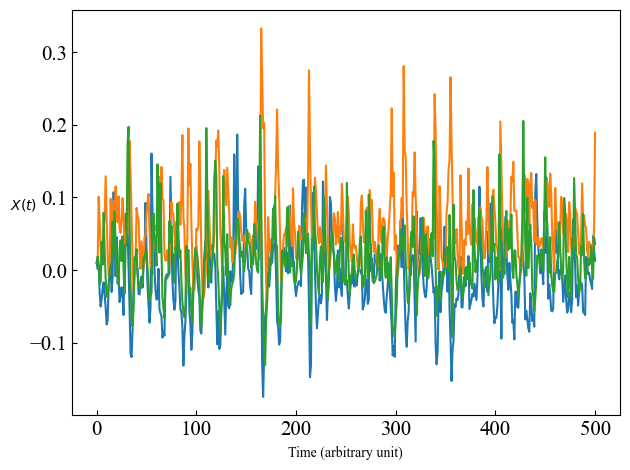

      x0(t)     x1(t)     x2(t)   x0(t-1)   x1(t-1)   x2(t-1)     e0(t)  \
0  0.001901  0.011141  0.018686  0.010000  0.010000  0.010000  0.001901   
1  0.006625  0.100868  0.008601  0.001901  0.011141  0.018686  0.011245   
2 -0.031553  0.068848 -0.019220  0.006625  0.100868  0.008601  0.015569   

      e1(t)     e2(t)  
0  0.001141  0.013686  
1  0.085954  0.001568  
2  0.014114  0.000040  


In [881]:
num_of_var = 3
filename = "sample_data_"+str(num_of_var)+".csv"
df = MakeB0B1(num_of_var)
df.to_csv(filename, sep=",", encoding="utf-8") # B0B1行列の保存
df2 = MakeDataframe(filename, Time=500)
df2.to_csv(filename.split(".csv")[0]+"_dataframe.csv", sep=",", encoding="utf-8") # 理想的モデルのデータ保存（この出力にはError termは含まれていない。そのためカーブはなめらかになる。）
MakeErrorTerm(num_of_var, Time=500) # エラー項を加えたデータフレームの保存（理想的モデルのカーブが見た目よくなるまで目視確認を繰り返す）
# ここでのスケールが、Error Termのスケールと合うようにする
# 平衡状態が長く続くようなカーブや爆発解になっている曲線は避ける
# 定常過程でないとは、シンバルの音のように弱まったり強くなったりするもの。定常過程は時系列のどこをとってもそれなりに値がある（ホワイトノイズは定常過程）。

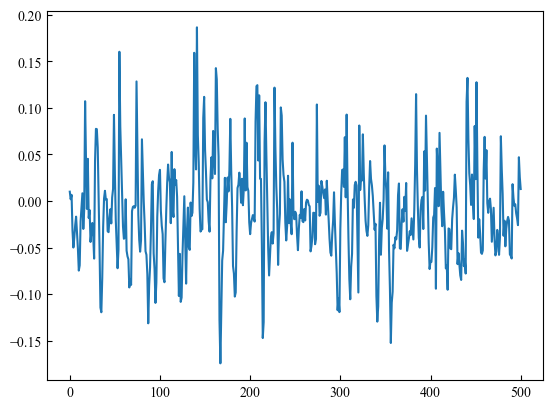

In [882]:
tmp = df2["x0"]
plt.plot(tmp)

C:\Users\Mitsu\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

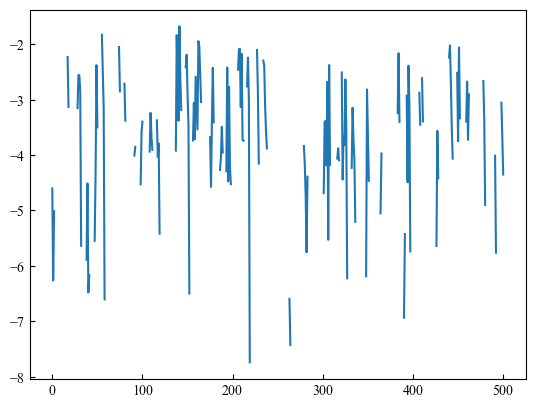

In [883]:
# plt.plot(tmp)
Passengers_log = np.log(tmp)
Passengers_log.plot()

<Axes: >

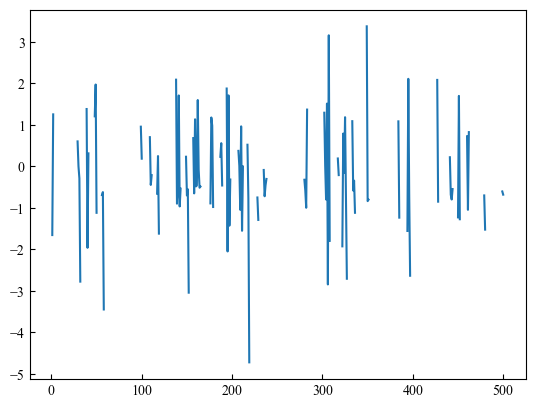

In [884]:
Passengers_log_diff = Passengers_log.diff(periods = 1)
Passengers_log_diff.plot()

<Axes: >

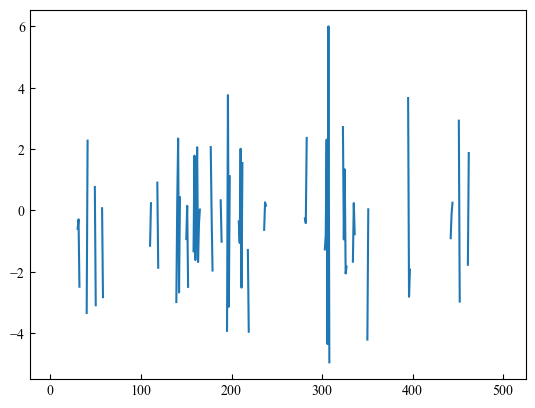

In [885]:
Passengers_sdiff2 = Passengers_log_diff.diff()
Passengers_sdiff2.plot()